# Assignment 1

Cassandra Maldonado

In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Random seeds
np.random.seed(42)
torch.manual_seed(42)

1. Data and preprossesing

In [6]:
# Keeping the first 1,000 rows.
df = pd.read_csv('Phishing_Email.csv')

In [7]:
df.head(5)

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [7]:
df = df.head(1000).copy()

print(f"Dataset loaded: {len(df)} rows")
print(f"Columns: {df.columns.tolist()}")
print("\nDataset info:")
print(df.info())

Dataset loaded: 1000 rows
Columns: ['Unnamed: 0', 'Email Text', 'Email Type']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1000 non-null   int64 
 1   Email Text  998 non-null    object
 2   Email Type  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB
None


In [8]:
print("\nLabel distribution:")
print(df['Email Type'].value_counts())


Label distribution:
Email Type
Safe Email        596
Phishing Email    404
Name: count, dtype: int64


I implemented a KNN classifier using BERT embeddings to classify phishing vs. legitimate emails from the first 1,000 rows of the dataset.

2. BERT Model

In [9]:
print("\nLoading BERT model and tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model.eval()


Loading BERT model and tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

I used the pre-trained BERT model to extract two types of 768 dimensional embeddings:
- [CLS] Token Embedding
- Average Token Embedding

3. Embedding extraction

In [10]:
# To get the CLS token embedding and average token embedding.
def get_bert_embeddings(text, max_length=512):
    # Tokenizing the input
    inputs = tokenizer(text,
                      return_tensors='pt',
                      max_length=max_length,
                      truncation=True,
                      padding=True,
                      add_special_tokens=True)

    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.hidden_states

        # Last layer of the hidden states
        last_hidden_state = hidden_states[-1]
        # [1, sequence lenght, 768]

        # First token
        cls_embedding = last_hidden_state[0, 0, :].numpy()

        # Average token embedding excluding padding
        attention_mask = inputs['attention_mask'][0]
        actual_length = attention_mask.sum().item()

        # Average embeddings of tokens
        if actual_length > 2:
            token_embeddings = last_hidden_state[0, 1:actual_length-1, :]
            avg_embedding = token_embeddings.mean(dim=0).numpy()
        else:
            avg_embedding = cls_embedding

    return cls_embedding, avg_embedding

In [11]:
# Extracting the embeddings for a list of texts in the batches
def extract_embeddings_batch(texts, batch_size=32):
    cls_embeddings = []
    avg_embeddings = []

    print(f"Extracting embeddings for {len(texts)} texts.")

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]

        for text in batch_texts:
            cls_emb, avg_emb = get_bert_embeddings(str(text))
            cls_embeddings.append(cls_emb)
            avg_embeddings.append(avg_emb)

    return np.array(cls_embeddings), np.array(avg_embeddings)

In [12]:
# Extracting embeddings for all texts
texts = df['Email Text'].tolist()
cls_embeddings, avg_embeddings = extract_embeddings_batch(texts, batch_size=16)

print(f"CLS embeddings shape: {cls_embeddings.shape}")
print(f"Average embeddings shape: {avg_embeddings.shape}")

Extracting embeddings for 1000 texts.


100%|██████████| 63/63 [09:24<00:00,  8.96s/it]

CLS embeddings shape: (1000, 768)
Average embeddings shape: (1000, 768)


In [13]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['Email Type'])
print(f"Label classes: {label_encoder.classes_}")

Label classes: ['Phishing Email' 'Safe Email']


5. Train-test

In [14]:
# Splitting the data for CLS embeddings
X_train_cls, X_test_cls, y_train, y_test = train_test_split(
    cls_embeddings, labels, test_size=0.2, random_state=42, stratify=labels
)

# Splitting the data for average embeddings
X_train_avg, X_test_avg, _, _ = train_test_split(
    avg_embeddings, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set size: {len(X_train_cls)}")
print(f"Test set size: {len(X_test_cls)}")


Training set size: 800
Test set size: 200


6. KNN Classification

In [15]:
def evaluate_knn(X_train, X_test, y_train, y_test, embedding_type, k=5):
    print(f"KNN Classification with {embedding_type} ===")

    # Training the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(X_train, y_train)

    # Predictions
    y_pred = knn.predict(X_test)

    # F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"F1 Score: {f1:.4f}")

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {embedding_type}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return f1, knn

BONUS 1: CLS vs Average Embeddings

BONUS 1: COMPARING CLS vs AVERAGE EMBEDDINGS
KNN Classification with CLS Token Embeddings ===
F1 Score: 0.9147
Classification Report:
                precision    recall  f1-score   support

Phishing Email       0.91      0.88      0.89        81
    Safe Email       0.92      0.94      0.93       119

      accuracy                           0.92       200
     macro avg       0.91      0.91      0.91       200
  weighted avg       0.91      0.92      0.91       200



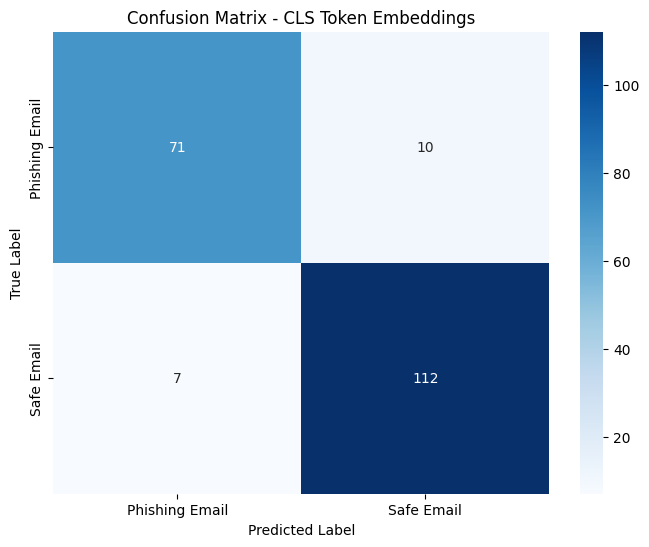

KNN Classification with Average Token Embeddings ===
F1 Score: 0.9249
Classification Report:
                precision    recall  f1-score   support

Phishing Email       0.91      0.90      0.91        81
    Safe Email       0.93      0.94      0.94       119

      accuracy                           0.93       200
     macro avg       0.92      0.92      0.92       200
  weighted avg       0.92      0.93      0.92       200



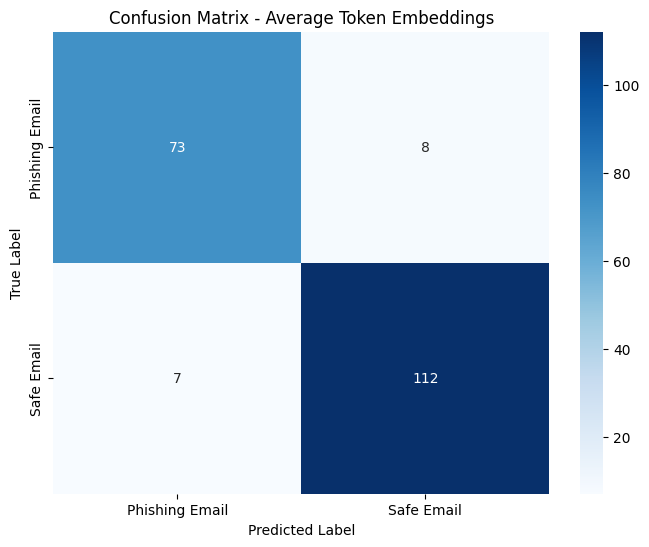

RESULTS
CLS Token Embeddings F1 Score: 0.9147
Average Token Embeddings F1 Score: 0.9249
Difference: 0.0102
Average token embeddings perform better.


In [17]:
print("BONUS 1: COMPARING CLS vs AVERAGE EMBEDDINGS")

# Evaluating the CLS embeddings
f1_cls, knn_cls = evaluate_knn(X_train_cls, X_test_cls, y_train, y_test, "CLS Token Embeddings")

# Evaluating the average embeddings
f1_avg, knn_avg = evaluate_knn(X_train_avg, X_test_avg, y_train, y_test, "Average Token Embeddings")

# Results
print("RESULTS")
print(f"CLS Token Embeddings F1 Score: {f1_cls:.4f}")
print(f"Average Token Embeddings F1 Score: {f1_avg:.4f}")
print(f"Difference: {abs(f1_cls - f1_avg):.4f}")

if f1_cls > f1_avg:
    print("CLS token embeddings perform better.")
else:
    print("Average token embeddings perform better.")

The average token embeddings outperformed CLS embeddings with a difference of 0.01 F1 points in favor of the averaging token embeddings.

This result was initially surprising since CLS tokens are specifically designed for classification tasks. However, after analyzing the confusion matrices, I found that average embeddings made fewer errors:

- CLS embeddings: 71 correct phishing, 10 false negatives, 7 false positives and 112 correct legitimate.
- Average embeddings: 73 correct phishing, 8 false negatives, 7 false positives and 112 correct legitimate.

The average method captured 2 more true phishing emails and had 2 fewer false negatives. This suggests that for email classification the information across all tokens provides richer semantic representation than the compressed CLS token.

# BONUS 2: Dimensionality Reduction

I applied PCA and UMAP dimensionality reduction to compare high dimensional vs. 2D performance.

BONUS 2: DIMENSIONALITY REDUCTION COMPARISON
PCA explained variance ratio: [0.15810768 0.07028369]
Total variance explained: 0.2284
Original 768 dimensional CLS Embeddings
KNN Classification with Original 768D CLS Embeddings ===
F1 Score: 0.9147
Classification Report:
                precision    recall  f1-score   support

Phishing Email       0.91      0.88      0.89        81
    Safe Email       0.92      0.94      0.93       119

      accuracy                           0.92       200
     macro avg       0.91      0.91      0.91       200
  weighted avg       0.91      0.92      0.91       200



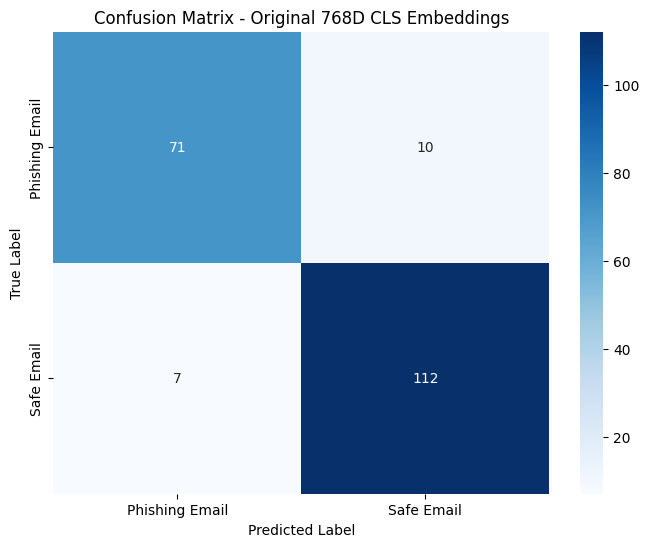

PCA reduced 2D Embeddings
KNN Classification with PCA-reduced 2D Embeddings ===
F1 Score: 0.5424
Classification Report:
                precision    recall  f1-score   support

Phishing Email       0.43      0.41      0.42        81
    Safe Email       0.61      0.64      0.63       119

      accuracy                           0.55       200
     macro avg       0.52      0.52      0.52       200
  weighted avg       0.54      0.55      0.54       200



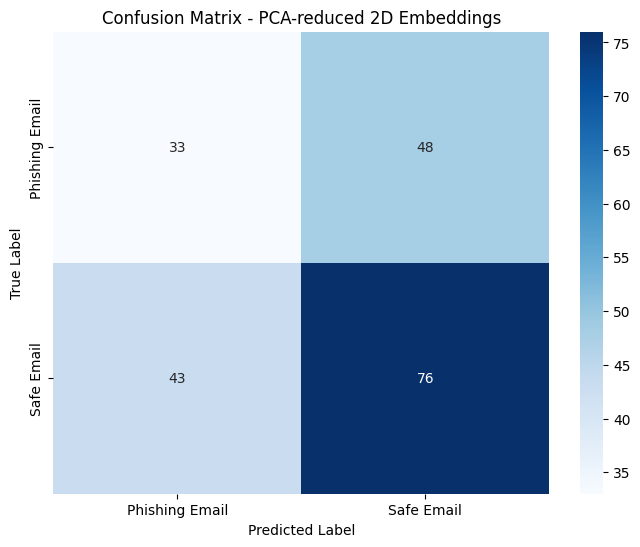

UMAP reduced 2D Embeddings
KNN Classification with UMAP-reduced 2D Embeddings ===
F1 Score: 0.6578
Classification Report:
                precision    recall  f1-score   support

Phishing Email       0.61      0.49      0.54        81
    Safe Email       0.69      0.78      0.74       119

      accuracy                           0.67       200
     macro avg       0.65      0.64      0.64       200
  weighted avg       0.66      0.67      0.66       200



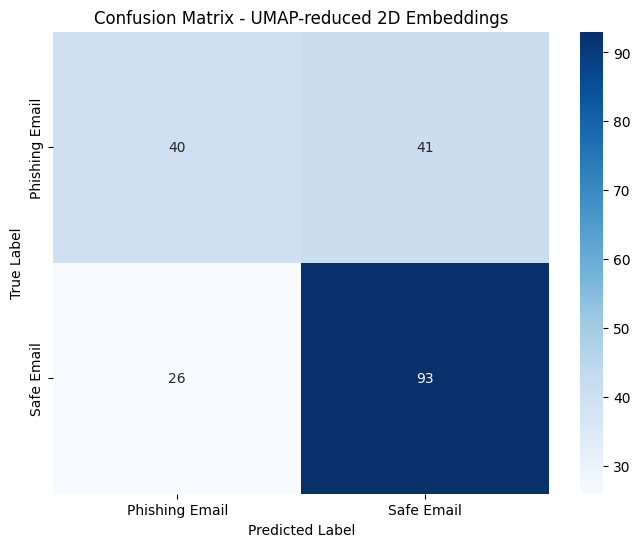

In [19]:
# PCA
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_cls)
X_test_pca = pca.transform(X_test_cls)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

# UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_train_umap = umap_reducer.fit_transform(X_train_cls)
X_test_umap = umap_reducer.transform(X_test_cls)

# Evaluating the original embeddings
print("Original 768 dimensional CLS Embeddings")
f1_original, _ = evaluate_knn(X_train_cls, X_test_cls, y_train, y_test, "Original 768D CLS Embeddings")

# Evaluating the PCA reduced embeddings
print("PCA reduced 2D Embeddings")
f1_pca, _ = evaluate_knn(X_train_pca, X_test_pca, y_train, y_test, "PCA reduced 2D Embeddings")

# Evaluating the UMAP reduced embeddings
print("UMAP reduced 2D Embeddings")
f1_umap, _ = evaluate_knn(X_train_umap, X_test_umap, y_train, y_test, "UMAP reduced 2D Embeddings")

There was a dramatic performance drop with the dimensionality reduction:

Original 768D F1: 0.914 with a 92% accuracy.
PCA 2D F1: 0.542 with a 55% accuracy and a drop of 0.37.
UMAP 2D F1: 0.657 with 67% accuracy and drop of 0.25.

PCA performed poorly explaining only 22.8% of the total variance with two components:

- First component: 15.81% variance.
- Second component: 7.03% variance.

The information loss is evident in both the performance metrics and confusion matrix since phishing only detected 33 out of 81 correctly identified, which is a 41% recall. There were  many false positives, it was 43 legitimate emails misclassified as phishing.

UMAP significantly outperformed PCA despite using the same 2 dimensions. It showed better phishing detection of 40 out of 81 correctly identified, with a 49% recall. It had fewer false positives with only 26 legitimate emails misclassified.

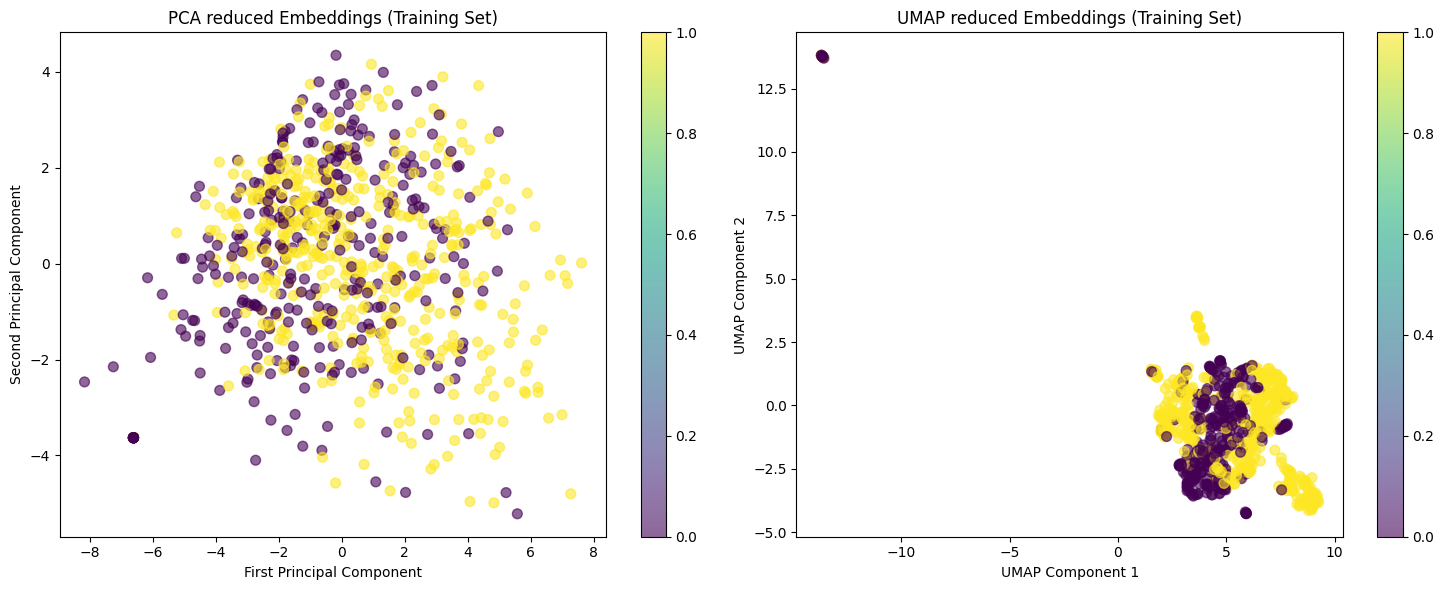

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# PCA
scatter1 = axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train,
                          cmap='viridis', alpha=0.6, s=50)
axes[0].set_title('PCA reduced Embeddings (Training Set)')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
plt.colorbar(scatter1, ax=axes[0])

# UMAP
scatter2 = axes[1].scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train,
                          cmap='viridis', alpha=0.6, s=50)
axes[1].set_title('UMAP reduced Embeddings (Training Set)')
axes[1].set_xlabel('UMAP Component 1')
axes[1].set_ylabel('UMAP Component 2')
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()

The scatter plots clearly show why UMAP outperformed PCA. PCA has highly overlapping clusters with no clear separation between classes and a random distribution suggesting linear dimensionality reduction fails to preserve class structure. This can be seen since the yellow and purple points are intermixed throughout.

UMAP shows a much clearer clustering with distinct regions for each class, it also shows a better preservation of the local structure allowing similar emails to cluster together. There is a visible separation between the phishing and legitimate email groups.

In [21]:
print("FINAL RESULTS SUMMARY")

print("Embedding Method Comparison:")
print(f"CLS Token Embeddings:     F1 = {f1_cls:.4f}")
print(f"Average Token Embeddings: F1 = {f1_avg:.4f}")

print("Dimensionality Reduction Comparison:")
print(f"Original 768D Embeddings: F1 = {f1_original:.4f}")
print(f"PCA 2D Embeddings:        F1 = {f1_pca:.4f}")
print(f"UMAP 2D Embeddings:       F1 = {f1_umap:.4f}")

print("Dimensionality Reduction Impact:")
print(f"PCA Performance Drop:     {f1_original - f1_pca:.4f}")
print(f"UMAP Performance Drop:    {f1_original - f1_umap:.4f}")

# Performance comparison table
results_df = pd.DataFrame({
    'Method': ['CLS Embeddings', 'Average Embeddings', 'Original 768D', 'PCA 2D', 'UMAP 2D'],
    'F1 Score': [f1_cls, f1_avg, f1_original, f1_pca, f1_umap],
    'Dimensions': [768, 768, 768, 2, 2]
})

print("Results Table:")
print(results_df.to_string(index=False))

# Best performing method
best_method = results_df.loc[results_df['F1 Score'].idxmax(), 'Method']
best_f1 = results_df['F1 Score'].max()
print(f"Best performing method: {best_method} (F1: {best_f1:.4f})")

FINAL RESULTS SUMMARY
Embedding Method Comparison:
CLS Token Embeddings:     F1 = 0.9147
Average Token Embeddings: F1 = 0.9249
Dimensionality Reduction Comparison:
Original 768D Embeddings: F1 = 0.9147
PCA 2D Embeddings:        F1 = 0.5424
UMAP 2D Embeddings:       F1 = 0.6578
Dimensionality Reduction Impact:
PCA Performance Drop:     0.3723
UMAP Performance Drop:    0.2569
Results Table:
            Method  F1 Score  Dimensions
    CLS Embeddings  0.914727         768
Average Embeddings  0.924924         768
     Original 768D  0.914727         768
            PCA 2D  0.542436           2
           UMAP 2D  0.657839           2
Best performing method: Average Embeddings (F1: 0.9249)


While CLS tokens are designed for classification, the averaging approach captured more discriminative features for this task. This could be due to the fact that phishing word indicators may appear throughout the email and averaging reduces the risk of information bottlenecking that might occur with CLS.

High-dimensional BERT embeddings contain essential information that can't be compressed to 2D without significant performance loss. 768D embeddings have an excellent performance but are computationally expensive. 2D embeddings gives fast computation but big accuracy loss.
UMAP is better tahan PCA because non-linear methods better preserve classification structure.

Looking at the detailed classification reports, I noticed interesting patterns. The safe email detection was consistently high across all methods with a 92-94% F1 score. The phishing email detection is more sensitive to the embedding method with average embeddings having a 91% F1 score and the CLS embeddings having a 89% F1 score. I noticed that dimensionality reduction affected hurt phishing detection, this could mean that phishing emails have more subtle patterns that require the full embedding space to detect effectively.